### *Questions to be addressed in this notebook*

* *What is the performance of Underdogs in March Madness*
* *Which team(s) is/are the ultimate Underdog*
* *Are there still underdogs?*

## Table of Contents

1. ) [Introduction](#Overview)
2. ) [Analysis](#Analysis)
3. ) [Results](#Results)
4. ) [Conclusions](#Conclusions)


***Skip to the Conclusion to eschew technical steps

# Introduction

Before the questions at hand can be answered, there are many technical steps that must be taken to enable a thorough analysis

## Problem Statement

March Madness is one of the most popular offseasons in college sports. Many people heavily rely upon seed to select their winners in March Madness. 
This Notebook will focus on the Underdogs of March Madness.

## Data Background

Data was obtained from https://data.world/sports/ncaa-mens-march-madness

Data Concerns:
* Data spans 1985-2016 
* Lacks an underdog metric or variable
* Contains 10 variables initially

*In future versions this data will be manually scraped to stay up to date*

#### **Notes** for a non-basketball fan: 
* Seed is inversely related to good teams 
Thus, higher seed is lower ranking. Concretely, seed 1 is the best and 16 is the worst

The Goal of the following steps is to address the Data Concerns

## Set Up

### Importing 

In [1]:
# Import the necessary Python libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import matplotlib.dates as mdates
from datetime import datetime
from sklearn.linear_model import LinearRegression


# ignore warnings
import warnings 
warnings.filterwarnings("ignore")

renamed CSV from "NCAA Mens March Madness Historical Results.csv" to "March_Madness_Games.csv" for convenience

In [2]:
mm_df= pd.read_csv("March_Madness_Games.csv")
mm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date           2050 non-null   object
 1   Round          2050 non-null   object
 2   Region         2038 non-null   object
 3   Winning Seed   2050 non-null   int64 
 4   Winner         2050 non-null   object
 5   Winning Score  2050 non-null   int64 
 6   Losing Seed    2050 non-null   int64 
 7   Loser          2050 non-null   object
 8   Losing Score   2050 non-null   int64 
 9   Overtime       130 non-null    object
dtypes: int64(4), object(6)
memory usage: 160.3+ KB


Check data by printing first 5 lines

In [3]:
mm_df.head() 

,Date,Round,Region,Winning Seed,Winner,Winning Score,Losing Seed,Loser,Losing Score,Overtime
0,3/14/85,Round of 64,East,1,Georgetown,68,16,Lehigh,43,NaN
1,3/14/85,Round of 64,East,4,"Loyola, Illinois",59,13,Iona,58,NaN
2,3/14/85,Round of 64,East,5,Southern Methodist,85,12,Old Dominion,68,NaN
3,3/14/85,Round of 64,East,8,Temple,60,9,Virginia Tech,57,NaN
4,3/14/85,Round of 64,Midwest,1,Oklahoma,96,16,North Carolina A&T,83,NaN


## Data Cleaning

Testing Code: Saved for the developer

In [4]:
#Testing (save for .py version)
# date_time_str= (mm_df["Date"][0])
# date_time_obj = datetime.strptime(date_time_str, '%m/%d/%y')
# date_time_str

Convert String to DateTime Object

Modify several Columns within the Dataframe. Note: Play-in games only started in 2001. As these games are not significant we are excluding them from our Data

In [5]:
#Convert String to DateTime Object
mm_df["Date"]= pd.to_datetime(mm_df['Date'], format='%m/%d/%y').dt.date

#Create Year Variable
mm_df['Year'] = pd.DatetimeIndex(mm_df['Date']).year 

#Create Total Points per game (not including OT) Variable
mm_df["Total Score"]= mm_df["Winning Score"]+ mm_df["Losing Score"]

###Detect Cases where underdog wins (Save for .py version)
# mm_df["Underdog Wins"]= mm_df["Winning Seed"] < 

#Exclude all play in games (11, 12, 16, in Opening Round)
#PLAY IN GAMES ONLY STARTED IN 2001
not_playin_game= mm_df["Round"] != "Opening Round"

#Create Variable Underdog
# detect when lower seed wins; when same seed ignore (or later could look up ranking of that year and pick based on higher team ranked)
total_games= len(mm_df)
# mm_df[mm_df["Winning Seed"] > mm_df["Losing Seed"]]
mm_df["Underdog"]= mm_df["Winning Seed"] > mm_df["Losing Seed"]


In [6]:
#Create Seed Differential Variable to express the number of seeds between losing and winning teams. A negative represents a lower seeded team
#total difference in seeds between teams
mm_df["Seed Differential"]= mm_df["Winning Seed"]- mm_df["Losing Seed"]


The following is more testing code for the developer

In [7]:
# mm_df[mm_df["Seed Differential"]==]
#mm_df.loc[(mm_df['Winning Seed'] == 1) & (mm_df['Losing Seed'] == 1)]

The following removes games where there is no underdog

In [8]:
#remove same seed games (number of same seed games)
mm_df[mm_df["Winning Seed"]== mm_df["Losing Seed"]]

#temporarily remove same Seed games
diff_seed= mm_df["Winning Seed"]!= mm_df["Losing Seed"]
mm_df= mm_df[diff_seed]

More testing:

In [9]:

#Testing (Save for .py version later)
#CHECK LEN IS DIFFERENT
# print(len(mm_df[not_playin_game]) != len(mm_df))
# mm_df= mm_df[not_playin_game] # len(mm_df)
#check that all have been removed
# check= mm_df["Round"] == "Opening Round"
# mm_df[check]

### Completed Dataset

## Variable Examination

In [10]:
#Listing Final Variables
col_name = mm_df.columns.values.tolist()
col_name

['Date',
 'Round',
 'Region',
 'Winning Seed',
 'Winner',
 'Winning Score',
 'Losing Seed',
 'Loser',
 'Losing Score',
 'Overtime',
 'Year',
 'Total Score',
 'Underdog',
 'Seed Differential']

*** Underdog is the most important variable we have to focus on. This is true when the lower seed team has won and false when not. We have already removed all same seed games from out dataset

# Analysis

## Question 1- Underdog Performance

### Step 1: Total Results

In [11]:
#Percentage of lower seed/ underdog winning
underdog_wins= len(mm_df[mm_df["Winning Seed"] > mm_df["Losing Seed"]])
underdog_pct= underdog_wins/ total_games
favorited_wins= total_games- underdog_wins
per_fav_win =favorited_wins/len(mm_df)

print(f"The expected team won {per_fav_win:.2%} percent of the games")

The expected team won 74.65% percent of the games


### Step 2: Seed Differentials:

To ease our understanding of the performance of Underdog winners, we will split the data into <u>Seed Differentials</u>

*what does this mean???*

A <u>Seed Differentials</u> is just the difference in seeds that was in place when an Underdog team won. For example, a 4 seed beating a 1 seed would have a seed differential of 3. This is just a rote way to capture what the difference is in games. 

In [12]:
underdog_df= mm_df[mm_df["Underdog"]== True]
underdog_df

# underdog_df[underdog_df["Seed Differential"]]
underdog_df["Seed Differential"].value_counts()
underdog_df["Seed Differential"].describe()
pre_list= list(underdog_df["Seed Differential"])

category_dict= {}

for diff in pre_list:
    cat_val= None
    if diff<4:
        cat_val= "1-3 Seed Difference"
    elif diff>3 and diff<7:
        cat_val= "4-6 Seed Difference"
    elif diff>6 and diff<10:
        cat_val= "7-9 Seed Difference"
    elif diff>9:
        cat_val= "10-13 Seed Difference"

    if not cat_val in category_dict:
        category_dict[cat_val]= 0
    category_dict[cat_val]+= 1
    
stor_val= sum(category_dict.values())
category_dict= {k:v/(stor_val) for (k,v) in category_dict.items()}
(category_dict)

# category_dict= {}
# for val in category_list:
    
#<1-3; 4-6,7-9; 10-13

# underdog_df["Seed Differential"].value_counts()
# mm_df[mm_df["Seed Differential"]== 13]

{'1-3 Seed Difference': 0.4920071047957371,
 '4-6 Seed Difference': 0.19005328596802842,
 '7-9 Seed Difference': 0.261101243339254,
 '10-13 Seed Difference': 0.056838365896980464}

The interpretation of this dictionary is that teams with a 1-3 seed difference have the highest winning percentage at 49.2%, followed by teams with a 7-9 seed difference at 26.1%, teams with a 4-6 seed difference at 19.0%, and teams with a 10-13 seed difference at 5.7%.

###### Meaning:

This suggests that the seed difference between two teams is a significant factor in determining their likelihood of winning a game in the NCAA basketball tournament. Teams with a smaller seed difference, particularly those with a 1-3 seed difference, have a higher chance of winning compared to teams with a larger seed difference. However, it is important to note that other factors, such as team performance and player injuries, can also influence the outcome of a game.

### Step 3: Victory Differences

The following graph is used to visualize, the percentages of Seed Differential within the bigger picture of how often the lower seed wins overall

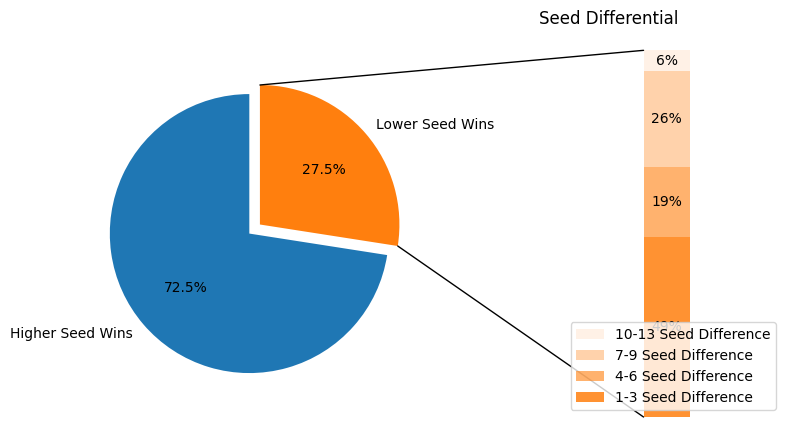

In [13]:
# make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
fig.subplots_adjust(wspace=0)

# pie chart parameters

overall_ratios = sizes = [favorited_wins, underdog_wins]
labels = "Higher Seed Wins", "Lower Seed Wins"
explode = [0.1, 0]
# rotate so that first wedge is split by the x-axis
angle = -90 * overall_ratios[0]
wedges, *_ = ax1.pie(overall_ratios, autopct='%1.1f%%', startangle=angle,
                     labels=labels, explode=explode)

# bar chart parameters
### Seed of the underdog


# underdog
# divide the seed differential from the total

age_ratios = category_dict.values()
age_labels =  category_dict.keys()
bottom = 1
width = .2

# Adding from the top matches the legend.
for j, (height, label) in enumerate(reversed([*zip(age_ratios, age_labels)])):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom, color='C1', label=label,
                 alpha=0.1 + 0.25 * j)
    ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')

ax2.set_title('Seed Differential')
ax2.legend()
ax2.axis('off')
ax2.set_xlim(- 5 * width, 2.5 * width)

###DRAWING LINES

# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[1].theta1, wedges[1].theta2
center, r = wedges[1].center, wedges[1].r
bar_height = sum(age_ratios)

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(1)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(1)

plt.show()


In this plot, the conjoined chart (right) represents the difference among lower seed teams

This code generates a graph that shows the winning percentages for higher-seeded and lower-seeded teams in the NCAA basketball tournament. The left side of the graph is a pie chart that shows the overall percentage of wins for higher-seeded and lower-seeded teams. The right side of the graph is a bar chart that shows the percentage of wins for each seed difference (the difference in seeding between two teams).

The pie chart and bar chart are connected by lines that show the relationship between the overall winning percentages and the winning percentages for each seed difference. The pie chart and bar chart help to visualize which teams are more likely to win based on their seeding.

This graph can be helpful to understand how seeding affects the likelihood of a team winning a game in the NCAA basketball tournament.





## Question 2- Ultimate Underdog

#### Lowest Seed teams to win (*)

In [14]:
largest_upset= underdog_df["Seed Differential"].max()
seed_15= underdog_df[mm_df["Seed Differential"]== largest_upset]
seed_15

,Date,Round,Region,Winning Seed,Winner,Winning Score,Losing Seed,Loser,Losing Score,Overtime,Year,Total Score,Underdog,Seed Differential
381,1991-03-14,Round of 64,East,15,Richmond,73,2,Syracuse,69,NaN,1991,142,True,13
519,1993-03-18,Round of 64,West,15,Santa Clara,64,2,Arizona,61,NaN,1993,125,True,13
775,1997-03-14,Round of 64,East,15,Coppin State,78,2,South Carolina,65,NaN,1997,143,True,13
1024,2001-03-15,Round of 64,West,15,Hampton,58,2,Iowa State,57,NaN,2001,115,True,13
1746,2012-03-16,Round of 64,South,15,Lehigh,75,2,Duke,70,NaN,2012,145,True,13
1750,2012-03-16,Round of 64,West,15,Norfolk State,86,2,Missouri,84,NaN,2012,170,True,13
1813,2013-03-22,Round of 64,South,15,Florida Gulf Coast,78,2,Georgetown,68,NaN,2013,146,True,13
2008,2016-03-18,Round of 64,Midwest,15,Middle Tennessee State,90,2,Michigan State,81,NaN,2016,171,True,13


*As of 2018, there is 1 16-seed team win in March Madness, UMBC.

In [15]:
#Plotting
# total underdog win ratio per season
# total underdog per round
# among the top 4 seeds which is most likely to lose?

# ratio of their appearances
underdog_frame= mm_df[["Winner", "Underdog"]].groupby("Winner").sum().sort_values(["Underdog"], ascending= False).head(10)

test= underdog_frame["Underdog"]
                                
input_val= dict(test)

underdog_frame


,Underdog
Winner,
Villanova,15
Michigan State,14
Syracuse,11
Butler,10
Gonzaga,10
Connecticut,10
Arizona,10
Temple,10
"Xavier, Ohio",9


### Teams with the Most Underdog Wins

In [16]:
year_frame= mm_df[["Date", "Region", "Underdog"]] #farthest underdogs per year

underdog_frame= mm_df[["Winner", "Underdog"]].groupby("Winner").sum().sort_values(["Underdog"], ascending= False).head(10)
underdog_frame

,Underdog
Winner,
Villanova,15
Michigan State,14
Syracuse,11
Butler,10
Gonzaga,10
Connecticut,10
Arizona,10
Temple,10
"Xavier, Ohio",9


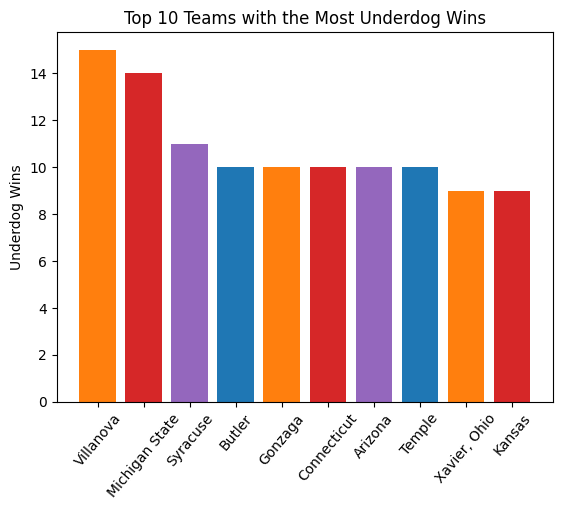

In [17]:
# Bar chart and then show years too
# Show the seeds they've won as underdogs

fig, ax = plt.subplots()

teams = input_val.keys()
counts = input_val.values()
bar_colors = ['tab:orange', 'tab:red', "tab:purple", 'tab:blue']

ax.bar(teams, counts,  color=bar_colors)

ax.set_ylabel('Underdog Wins')
ax.set_title('Top 10 Teams with the Most Underdog Wins')
ax.tick_params(axis='x', rotation=50)

# ax.legend(title='Fruit color')

plt.show()


### Most Successful Underdogs

In [18]:
#display teams in order of round

temp= mm_df.loc[(mm_df['Underdog'] == True) & (mm_df['Round'] == "National Championship")]
temp.sort_values("Winning Seed", ascending= False)

,Date,Round,Region,Winning Seed,Winner,Winning Score,Losing Seed,Loser,Losing Score,Overtime,Year,Total Score,Underdog,Seed Differential
62,1985-04-01,National Championship,National Championship,8,Villanova,66,1,Georgetown,64,NaN,1985,130,True,7
251,1988-04-04,National Championship,National Championship,6,Kansas,83,1,Oklahoma,79,NaN,1988,162,True,5
818,1997-03-31,National Championship,National Championship,4,Arizona,84,1,Kentucky,79,1 OT,1997,163,True,3
1199,2003-04-07,National Championship,National Championship,3,Syracuse,81,2,Kansas,78,NaN,2003,159,True,1
1391,2006-04-03,National Championship,National Championship,3,Florida,73,2,UCLA,57,NaN,2006,130,True,1
125,1986-03-31,National Championship,National Championship,2,Louisville,72,1,Duke,69,NaN,1986,141,True,1
2049,2016-04-04,National Championship,NaN,2,Villanova,77,1,North Carolina,74,NaN,2016,151,True,1


Many of the underdogs here are trivial, as it was only a difference of 1 seed. 
However, Villanova is the lowest underdog seed to ever win a national championship and they were also the first team in the modern era of March Madness to win.

## Question 3- Underdogs over Time

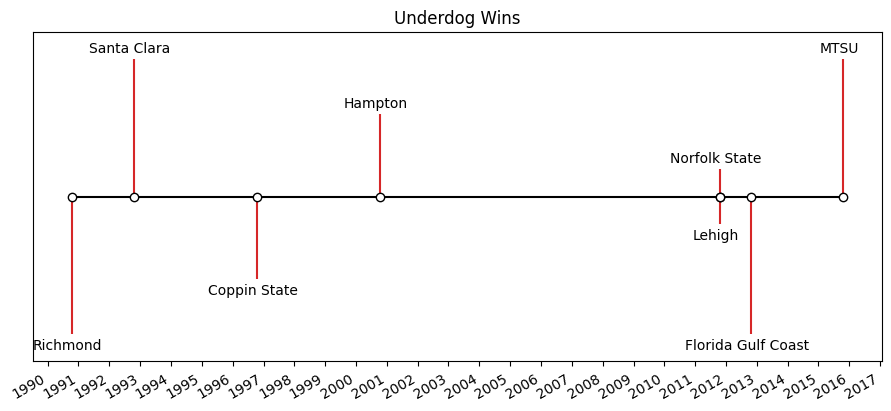

In [19]:

names= list(seed_15["Winner"])
names[-1]= "MTSU"
dates= list(seed_15["Date"])

# names = ['v2.2.4', 'v3.0.3', 'v3.0.2', 'v3.0.1', 'v3.0.0', 'v2.2.3',
#              'v2.2.2', 'v2.2.1', 'v2.2.0', 'v2.1.2', 'v2.1.1', 'v2.1.0',
#              'v2.0.2', 'v2.0.1', 'v2.0.0', 'v1.5.3', 'v1.5.2', 'v1.5.1',
#              'v1.5.0', 'v1.4.3', 'v1.4.2', 'v1.4.1', 'v1.4.0']

# dates = ['2019-02-26', '2019-02-26', '2018-11-10', '2018-11-10',
#              '2018-09-18', '2018-08-10', '2018-03-17', '2018-03-16',
#              '2018-03-06', '2018-01-18', '2017-12-10', '2017-10-07',
#              '2017-05-10', '2017-05-02', '2017-01-17', '2016-09-09',
#              '2016-07-03', '2016-01-10', '2015-10-29', '2015-02-16',
#              '2014-10-26', '2014-10-18', '2014-08-26']

# Choose some nice levels
levels = np.tile([-5, 5, -3, 3, -1, 1],
                 int(np.ceil(len(dates)/6)))[:len(dates)]

# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True)
ax.set(title="Underdog Wins")

ax.vlines(dates, 0, levels, color="tab:red")  # The vertical stems.
ax.plot(dates, np.zeros_like(dates), "-o",
        color="k", markerfacecolor="w")  # Baseline and markers on it.

# annotate lines
for d, l, r in zip(dates, levels, names):
    ax.annotate(r, xy=(d, l),
                xytext=(-3, np.sign(l)*3), textcoords="offset points",
                horizontalalignment="center",
                verticalalignment="bottom" if l > 0 else "top")

# format xaxis with 12 month intervals
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# remove y axis and spines
ax.yaxis.set_visible(False)
# ax.spines[["left", "top", "right"]].set_visible(False)

ax.margins(y=0.1)
plt.show()

In [20]:
mm_df = mm_df.sort_values('Date')

# Group the data by year and calculate the total number of games and underdog wins
yearly_data = mm_df.groupby('Year').agg({'Underdog': ['count', 'sum']})

# Rename columns for clarity
yearly_data.columns = ['Total Games', 'Underdog Wins']

yearly_data['Underdog Win Percentage'] = yearly_data['Underdog Wins'] / yearly_data['Total Games']

print(yearly_data)

      Total Games  Underdog Wins  Underdog Win Percentage
Year                                                     
1985           62             18                 0.290323
1986           62             18                 0.290323
1987           62             18                 0.290323
1988           62             17                 0.274194
1989           62             20                 0.322581
1990           63             20                 0.317460
1991           63             16                 0.253968
1992           63             15                 0.238095
1993           61             12                 0.196721
1994           63             18                 0.285714
1995           62             14                 0.225806
1996           62             15                 0.241935
1997           62             16                 0.258065
1998           63             18                 0.285714
1999           61             23                 0.377049
2000          

In [21]:
print(yearly_data.columns)
# years = yearly_data.index.tolist()
# print(years)
# (yearly_data['Underdog Win Percentage']).tolist()

Index(['Total Games', 'Underdog Wins', 'Underdog Win Percentage'], dtype='object')


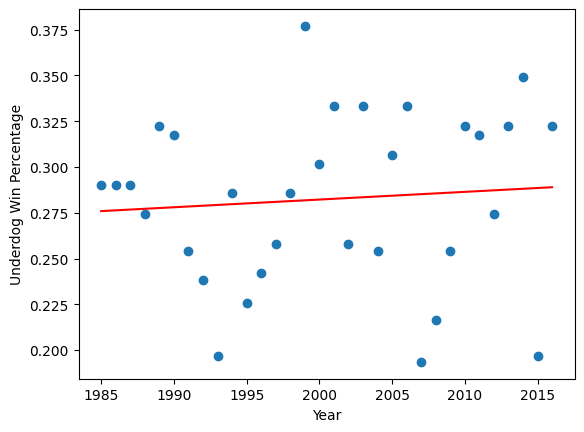

Model Coefficients:  [0.00042052]
Model Intercept:  -0.5588162352548726


In [22]:
X = pd.Series(yearly_data.index.tolist()).values.reshape(-1, 1)
y = (yearly_data['Underdog Win Percentage'])

regressor = LinearRegression()
regressor.fit(X, y)

y_pred = regressor.predict(X)

plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.xlabel('Year')
plt.ylabel('Underdog Win Percentage')
plt.show()

print('Model Coefficients: ', regressor.coef_)
print('Model Intercept: ', regressor.intercept_)


# Conclusions

* **Overall Victory**
    * While the underdog is more likely to lose in general almost a quarter of the time, there is undeniably a high enough presence of "Underdogs" winning to warrant excitement, and a good mix of lower seeded teams winning
* **Ultimate Underdog Team**
    * __Villonova__ is the ultimate underdog team having both the underdog wins and the biggest underdog championship
* **Underdogs over Time*
    * As the Coefficient is so drastically low, its safe to say to Underdogs are maintaining there ground in March Madness

## Next Steps

* Add more depth to the Underdog Criteria
    * Look at how teams in different Regions are ranked against each other in overall rankings to decide when a team is an underdog even though both teams are the same seeds across different regions
* Further Explore underdog teams
Evaluate more fine-grained variables involving the teams